# 09. 의사결정분석

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params
set_pyplot_params()

## 09.01. 진열대 위 물건 가격 추정

> 미국 TV 게임 쇼에서, 진열대 위 무건들의 가격을 맞추는 게임
> 
> 참가자 중 물건의 실제 가격보다 높지 않은, 가장 가까운 가격을 부르는 사람이 승리
> 
> A는 식기 세척기, 와인장, 노트북, 자동차에 \\$26,000를 예상 $\rightarrow$ 실제 물건의 값은 \\$25,347
> 
> B는 핀볼 게임 기계, 비디오 게임 기계, 미니 당구대, 바하마 여객선에  \\$21,500을 예상 $\rightarrow$ 실제 물건의 값은 \\$21,578
> 
> B의 예상가가 실제가보다 \\$78 낮아서, 진열대 가격을 맞추는 데에서 통과하였고, A에게 승리

<br>

### 베이지안 사고방식에서 접근

1. 우승 결과를 보기 전에, 진열대의 가격에 대해 참가자들은 어떤 사전 믿음이 있었는가?
2. 우승 결과를 본 후, 참가차들은 이런 믿음을 어떻게 갱신했을까?
3. 사후분포 기반으로, 참가자들은 예상가를 어떻게 적어야 할까?

<br>

## 09.02. 사전분포

- 2011년부터, 2012년 방영된 시즌의 진열대에 올라온 가격과, 참가들이 예상한 금액 데이터

In [2]:
import pandas as pd

In [3]:
download('https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2011.csv')
download('https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2012.csv')

In [4]:
def read_data(filename):

    """진열대 가격 데이터"""
    df = pd.read_csv(filename, index_col=0, skiprows=[1])
    return df.dropna().transpose()

In [5]:
df2011 = read_data('showcases.2011.csv')
df2012 = read_data('showcases.2012.csv')

df = pd.concat([df2011, df2012], ignore_index=True)

In [6]:
df.head()

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0
3,44432.0,31428.0,27000.0,38000.0,17432.0,-6572.0
4,24273.0,22320.0,18750.0,23000.0,5523.0,-680.0


In [7]:
print(df2011.shape, df2012.shape, df.shape)

(191, 6) (122, 6) (313, 6)


<br>

## 09.03. 커널 밀도 추정

- 데이터 셋에는 313개의 이전 진열대 가격이 기록 $\rightarrow$ **이를 가능한 가격의 모수에 대한 샘플이라고 가정**

    $\rightarrow$ 샘플을 통해, 진열대 가격의 사전분포를 추정
    
    $\rightarrow$ **샘플로 적절한 평활 분포를 추정하는 커널 밀도 추정 사용**
    
    https://darkpgmr.tistory.com/147
    
<br>

#### 밀도추정
- 데이터들의 분포로부터 원래 변수의 (확률) 분포 특성을 추정하고자 하는 것이 density estimation(밀도추정)
    - 즉, 어떤 변수 x의 밀도(density)를 추정하는 것은 x의 확률밀도함수(pdf, probability density function)를 추정하는 것과 동일한 말
    
* 어떤 변수 x의 확률밀도함수 f(x)가 아래 그림과 같을 때,




* 이 때, f(a)는 x = a에서의 확률밀도(probability density) 즉, 변수 x가 a라는 값을 가질 상대적인 가능성(relative likelihood)
- 밀도(density)와 확률(probability)을 구분해 보면 위 그림에서 x = a일 확률은 0이지만, 

    x = a에서의 density(밀도)는 f(a)로 0이 아니다. 
    
    그리고 x가 a, b 사이의 값을 가질 확률(probability)은 그 구간에서의 확률밀도함수의 적분값(면적)으로 계산
    
    **즉, density(밀도)는 확률밀도함수의 함수값이며 density를 일정 구간에 대해 적분하면 확률**
    




<br>

#### Parametric vs. Non-parametric 밀도추정

- 밀도추정(density estimation) 방법은 크게 parametric 방법과 non-parametric 방법으로 구분
    - Parametric 밀도추정은 미리 pdf(probability density function)에 대한 모델을 정해놓고 
    
        데이터들로부터 모델의 파라미터만 추정하는 방식이다. 
        
        예를 들어, '일일 교통량'이 정규분포를 따른다고 가정해 버리면 관측된 데이터들로부터 평균과 분산만 구하면 되기 때문에 밀도추정 문제가 비교적 간단한 문제가 되어 버린다.
        
        <br> 
        
    - 그런데 현실 문제에서 이렇게 모델이 미리 주어지는 경우는 많지 않으며 분포의 모델을 미리 안다는 것은 비현실적인 가정
    
    - **이 경우 어떠한 사전 정보나 지식 없이 순수하게 관측된 데이터만으로 확률밀도함수를 추정해야 하는데 이를 non-parametric density estimation**

     **Non-parametric 밀도추정의 가장 간단한 형태가 바로 히스토그램(histogram)**
     
     **즉, 관측된 데이터들로부터 히스토그램을 구한 후 구해진 히스토그램을 정규화하여 확률밀도함수로 사용**

 

#### Kernel Density Estimation (커널 밀도 추정)
- **non-parametric 밀도추정의 가장 단순한 형태인 히스토그램(histogram) 방법은 bin의 경계에서 불연속성이 나타난다는 점,**

    **bin의 크기 및 시작 위치에 따라서 히스토그램이 달라진다는 점,** 
    
    **고차원(high dimension) 데이터에는 메모리 문제 등으로 사용하기 힘들다는 점 등의 문제점**

- **Kernel Density Estimation (커널 밀도 추정) 방법은 non-parametric 밀도추정 방법 중 하나로서 커널함수(kernel function)를 이용하여 히스토그램 방법의 문제점을 개선**
    
    - **수학적으로 커널함수는 원점을 중심으로 좌우 대칭이면서 적분값이 1인 non-negative 함수로 정의되며 가우시언(Gaussian), Epanechnikov, uniform 함수 등이 대표적인 커널 함수들**
    
    






- **$x$를 변수(random variable), $x_1, x_2, \dots x_n$을 관측된 샘플 데이터, $K$를 커널 함수라 할 때**

    **KDE에서는 랜덤 변수 x에 대한 pdf(확률밀도함수)를 다음과 같이 추정**
    


- **위 식에서 $h$는 커널(kernel) 함수의 bandwidth 파라미터로서**

    **커널이 뽀족한 형태($h$가 작은 값)인지 완만한 형태($h$가 큰 값)인지를 조절하는 파라미터**
    
    - **수식적으로 보면 어렵지만 이를 직관적으로 이해하면 다음과 같음**
    
    1. **관측된 데이터 각각마다 해당 데이터 값을 중심으로 하는 커널 함수를 생성: $K(x-xi)$**

    2. **만들어진 커널 함수들을 모두 더한 후 전체 데이터 개수로 나눔**
    


* **히스토그램을 이용한 밀도추정 방법과 KDE 방법을 비교해 보면,**

    **히스토그램 방법은 이산적(discrete)으로 각 데이터에 대응되는 bin의 값을 증가시킴으로써 불연속성이 발생하는 반면**

    **KDE(커널밀도추정) 방법은 각 데이터를 커널 함수로 대치하여 더함으로써, 우상단의 래프와 같이 smooth한 확률밀도함수(pdf)를 얻을 수 있는 장점을 가짐**

 
#### 즉, KDE(Kernel Density Estimation)를 통해 얻은 확률밀도함수는 히스토그램 확률밀도함수를 스무딩(smoothing)한 것으로도 볼 수 있으며 
#### 이 때, 스무딩(smoothing) 정도는 아래 그림처럼 어떤 bandwidth 값의 커널 함수를 사용했으냐에 따라 달라진다.



* **실제 KDE를 사용할 때, 중요한 이슈는 어떤 커널 함수를 사용할지와 커널 함수의 bandwidth 파라미터인 h 값을 어떻게 잡을지이며,** 

    - **위키피디아에 의하면 가장 최적의 커널함수는 Epanechnikov 커널**
    - **계산의 편의상 Gaussian 커널함수도 많이 사용되며, Gaussian 커널함수를 사용할 경우 최적의 bandwidth 파라미터 값은 다음과 같음**



<br>


#### `scipy.stats.gaussian_kde(샘플)` : 샘플에 대한 추정 분포 객체 생성

In [10]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf
import numpy as np

In [11]:
def kde_from_sample(sample, qs):

    """샘플로부터 커널 밀도 추정값 생성"""
    kde = gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

<br>

* 진열대 1 금액의 분포를 추정

In [24]:
df['Showcase 1'].describe()

count      313.000000
mean     30299.488818
std       7145.705405
min      19563.000000
25%      24866.000000
50%      28958.000000
75%      34428.000000
max      58342.000000
Name: Showcase 1, dtype: float64

In [14]:
qs = np.linspace(0, 80000, 81)
prior1 = kde_from_sample(df['Showcase 1'], qs)

In [18]:
df[['Showcase 1']].head()

,Showcase 1
0,50969.0
1,21901.0
2,32815.0
3,44432.0
4,24273.0


In [16]:
prior1.head()

,probs
0.0,7.084244e-20
1000.0,2.993201e-18
2000.0,1.045021e-16


In [13]:
from utils import decorate

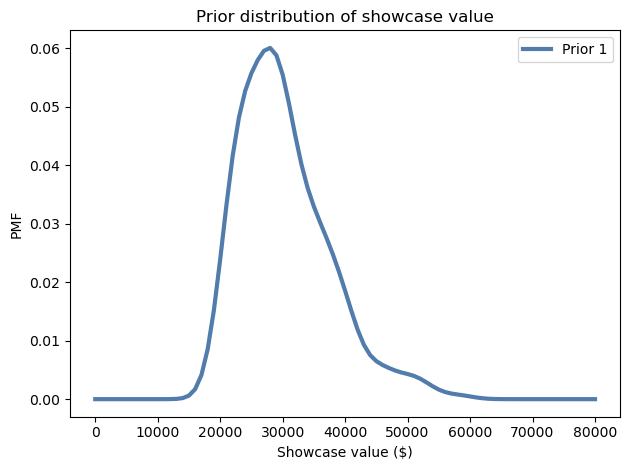

In [23]:
def decorate_value(title=''):
    
    decorate(xlabel='Showcase value ($)',
        ylabel='PMF',
        title=title)
    
prior1.plot(label='Prior 1')
decorate_value('Prior distribution of showcase value')

<br>

- 진열대 2 금액의 분포 추정

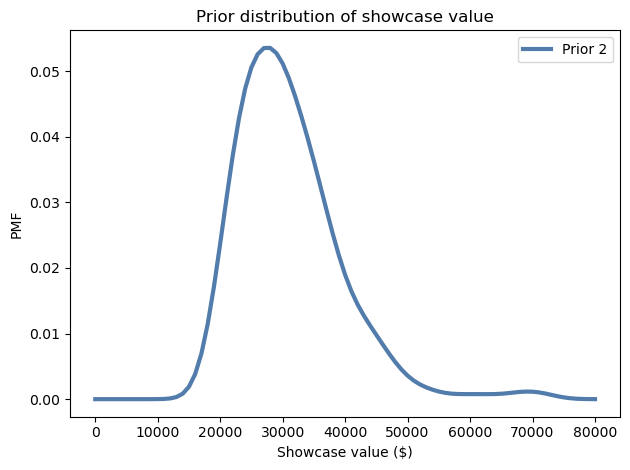

In [27]:
qs = np.linspace(0, 80000, 81)
prior2 = kde_from_sample(df['Showcase 2'], qs)

prior2.plot(label='Prior 2')
decorate_value('Prior distribution of showcase value')

<br>

## 09.04. 오차분포

- 사전 값을 갱신하기 위해서, 다음 질문에 대한 답이 필요
> 어떤 데이터를 고려하고 어떤 데이터를 값으로 사용해야 하는가?
>
> 가능도 함수를 구할 수 있는가? 각 가설 금액에 대해 데이터의 조건부 가능도를 계산할 수 있는가?

<br>

#### 질문의 답을 구하기 위해, 오차 특성에 따라 금액을 추측하는 도구 형태로 각 참가자를 모델링
- 참가자가 각 상품을 보고, 각각의 상품에 대한 값을 구하고, 이를 더한 것을 **`guess`**라고 할 때,

> **만약 실제 가격이 `price`이고, 참가자의 추측이 `guess`가 되도록 하는 가능도는?**

<br>

- **error = guess - price**로 정의하는 경우,

> **"참가자의 추측이 error만큼 빗나갈 가능도는?"**

<br>

* 참가자가 입찰한 금액과 실제 금액 간의 차이

In [33]:
sample_diff1 = df['Bid 1'] - df['Showcase 1']
print(sample_diff1.describe())

count      313.000000
mean     -4116.396166
std       6899.909806
min     -31374.000000
25%      -7800.000000
50%      -3902.000000
75%        -26.000000
max      14187.000000
dtype: float64


In [34]:
sample_diff2 = df['Bid 2'] - df['Showcase 2']
print(sample_diff2.describe())

count      313.000000
mean     -3675.891374
std       6886.260711
min     -43628.000000
25%      -7829.000000
50%      -3136.000000
75%        587.000000
max      25839.000000
dtype: float64


* 이 차이의 분포를 시각화하기 위해, KDE를 사용

In [30]:
qs = np.linspace(-40000, 20000, 61)
kde_diff1 = kde_from_sample(sample_diff1, qs)
kde_diff2 = kde_from_sample(sample_diff2, qs)

<br>

**입찰가가 너무 높은 쪽보다는 너무 낮은 쪽이 훨씬 많은 것으로 추정**
    - **게임의 규칙을 고려하였을 떄, 실제 가격보다 높게 입찰한 경우 무조건 탈락이기에 이는 합리적**

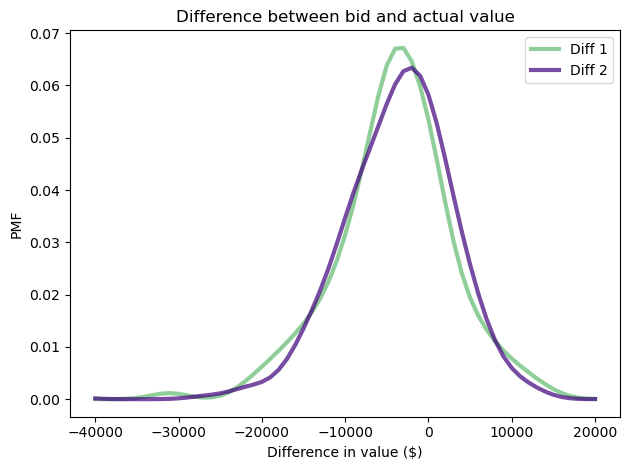

In [31]:
kde_diff1.plot(label='Diff 1', color='C8')
kde_diff2.plot(label='Diff 2', color='C4')

decorate(xlabel='Difference in value ($)',
        ylabel='PMF',
        title='Difference between bid and actual value')

<br>

#### 위 분포는 정규분포 형태로 모델링되어, 평균과 표준 편차로 요약 가능
* 참가자 1번의 차잇값에 대한 평균과 표준편차

In [40]:
mean_diff1 = sample_diff1.mean()
std_diff1 = sample_diff1.std()

print(" mean :", mean_diff1, "\n\n std_dev :", std_diff1)

 mean : -4116.3961661341855 

 std_dev : 6899.909806377115


<br>

**몇 가지 가정 추가**

> 참가자들이 전략적으로 다소 낮은 입찰가를 불렀다고 가정. 
> 
> 평균적으로 실제 추측값은 평균적으로 정확 (오차의 평균 = 0)
>
> 차이의 분포는 오차의 분포와 동일하다고 가정. 따라서 차이의 표준 편차는 오차의 표준편차와 동일

<br>

#### `scipy.stats.norm(평균, 표준편차)` : 정규분포 객체 생성

In [42]:
from scipy.stats import norm

- 오차가 -100일 때, 오차의 확률 밀도 함수 값

In [44]:
error_dist1 = norm(0, std_diff1)

error = -100
error_dist1.pdf(error)

5.7812405640086924e-05

#### 확률 밀도 함수 값은 확률이 아니므로, 값 자체는 큰 의미는 없음
#### 하지만, 확률에 비례하므로, 베이지안 갱신에서 가능도 처럼 사용 가능

<br>

## 09.05. 갱신

- 1번 참가자가 \\$23,000로 추측하였을 때, **추측값으로부터 사전분포(커널 밀도 추정 분포)의 각 가설 값을 빼면, 각 가설값에 대한 오차가 계산**

In [53]:
guess1 = 23000
error1 = guess1 - prior1.qs

In [54]:
error1

array([ 23000.,  22000.,  21000.,  20000.,  19000.,  18000.,  17000.,
        16000.,  15000.,  14000.,  13000.,  12000.,  11000.,  10000.,
         9000.,   8000.,   7000.,   6000.,   5000.,   4000.,   3000.,
         2000.,   1000.,      0.,  -1000.,  -2000.,  -3000.,  -4000.,
        -5000.,  -6000.,  -7000.,  -8000.,  -9000., -10000., -11000.,
       -12000., -13000., -14000., -15000., -16000., -17000., -18000.,
       -19000., -20000., -21000., -22000., -23000., -24000., -25000.,
       -26000., -27000., -28000., -29000., -30000., -31000., -32000.,
       -33000., -34000., -35000., -36000., -37000., -38000., -39000.,
       -40000., -41000., -42000., -43000., -44000., -45000., -46000.,
       -47000., -48000., -49000., -50000., -51000., -52000., -53000.,
       -54000., -55000., -56000., -57000.])

- **이 추정오차들에 대한 오차 확률 밀도 함수 값들은 가능도로 취급하여, 사전 분포를 갱신**

    $\rightarrow$ **사후분포**

In [55]:
likelihood1 = error_dist1.pdf(error1)
likelihood1

array([2.23489154e-07, 3.58513040e-07, 5.63159359e-07, 8.66234545e-07,
       1.30472065e-06, 1.92432055e-06, 2.77917020e-06, 3.93034537e-06,
       5.44282196e-06, 7.38066319e-06, 9.80041553e-06, 1.27429928e-05,
       1.62246833e-05, 2.02282757e-05, 2.46955864e-05, 2.95228084e-05,
       3.45600081e-05, 3.96157469e-05, 4.44671919e-05, 4.88752966e-05,
       5.26037798e-05, 5.54398875e-05, 5.72144298e-05, 5.78184776e-05,
       5.72144298e-05, 5.54398875e-05, 5.26037798e-05, 4.88752966e-05,
       4.44671919e-05, 3.96157469e-05, 3.45600081e-05, 2.95228084e-05,
       2.46955864e-05, 2.02282757e-05, 1.62246833e-05, 1.27429928e-05,
       9.80041553e-06, 7.38066319e-06, 5.44282196e-06, 3.93034537e-06,
       2.77917020e-06, 1.92432055e-06, 1.30472065e-06, 8.66234545e-07,
       5.63159359e-07, 3.58513040e-07, 2.23489154e-07, 1.36422433e-07,
       8.15441811e-08, 4.77285240e-08, 2.73552618e-08, 1.53525879e-08,
       8.43723515e-09, 4.54042554e-09, 2.39260391e-09, 1.23459041e-09,
      

In [56]:
posterior1 = prior1 * likelihood1
posterior1.normalize()

3.3889812097254624e-05

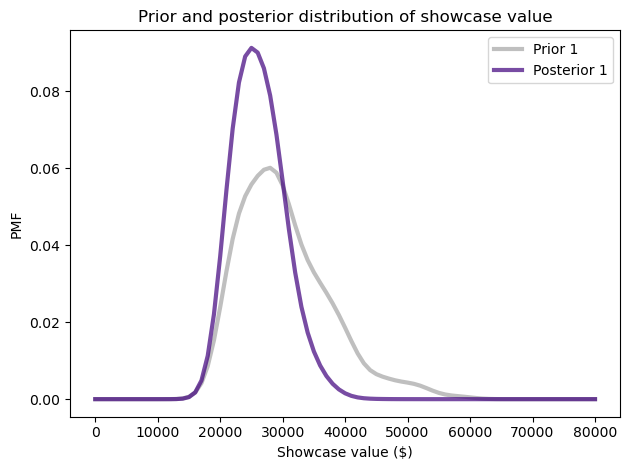

In [57]:
prior1.plot(color='C5', label='Prior 1')
posterior1.plot(color='C4', label='Posterior 1')

decorate_value('Prior and posterior distribution of showcase value')

#### 초기 추측값은 해당 값 범위에서 가장 낮은 값이므로, 사후분포는 왼쪽으로 이동
#### 사후분포의 평균값으로 얼마나 많이 이동했는 지를 확인 가능

In [58]:
prior1.mean(), posterior1.mean()

(30299.488817891375, 26192.02400239254)

<br>

#### 물건들을 보기 전에는 진열대 상품 가격이 약 \\$30,000일 것으로 생각 (= 사전분포의 평균)
#### \\$23,000이라고 추측한 후, 사전분포를 갱신
#### 사전분포와 추측한 값의 조합을(= 사후분포) 기반으로, 이제 실제값을 \\$26,000이라고 예상 (= 사후분포의 평균)

<br>

#### 2번 참가자가 \\$38,000이라고 추측하였을 때, 추정 오차의 분포를 나타내는 정규분포를 생성하고, 사전분포를 갱신
물건들을 보기 전에는, 진열대 상품 가격이 약 \\$31,000이라고 생각 (= 사전분포의 평균)

\\$38,000이라고 추측한 후, 사전분포를 갱신 $\rightarrow$ 갱신된 사후분포를 기반으로, 이제 실제값을 \\$34,000이라고 예상

In [60]:
mean_diff2 = sample_diff2.mean()
std_diff2 = sample_diff2.std()

error_dist2 = norm(0, std_diff2)

In [61]:
guess2 = 38000
error2 = guess2 - prior2.qs

In [63]:
likelihood2 = error_dist2.pdf(error2)
posterior2 = prior2 * likelihood2
posterior2.normalize()

2.6978123219107018e-05

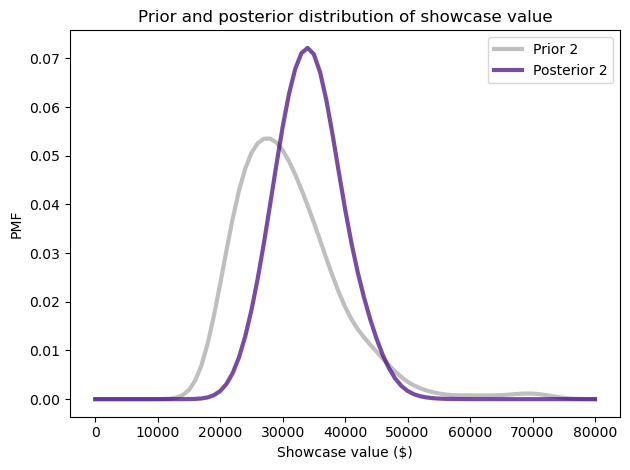

In [64]:
prior2.plot(color='C5', label='Prior 2')
posterior2.plot(color='C4', label='Posterior 2')

decorate_value('Prior and posterior distribution of showcase value')

In [65]:
prior2.mean(), posterior2.mean()

(31047.623719122505, 34305.201616424696)

<br>

## 09.06. 우승 확률

- 1번 참가자의 관점에서, 2번 참가자가 실제 가격보다 높게 입찰할 확률을 계산

    (진열대 물건의 가격은 무시하고, 이전 참가자의 기록만을 사용)
    

<br>

#### 2번 참가자가 실제보다 높은 금액을 입찰할 확률의 추정

In [66]:
def prob_overbid(sample_diff):

    """높게 입찰할 확률을 구함"""
    return np.mean(sample_diff > 0)

In [67]:
prob_overbid(sample_diff2)

0.29073482428115016

<br>

#### 1번 참가자가 \\$5,000 낮은 가격으로 입찰하였을 때, 2번 참가자가 더 낮게 입찰할 확률 (= 2번 참가자의 오차가 더 클 확률)

In [68]:
def prob_worse_than(diff, sample_diff):
    
    """주어진 diff보다 상대방의 diff가 더 낮을 확률"""
    return np.mean(sample_diff < diff)

- 2번 참가자가 원 가격 대비 \\$5,000 더 낮게 입찰할 확률

In [69]:
prob_worse_than(-5000, sample_diff2)

0.38338658146964855

- \\$10,000 더 낮게 입찰할 확률

In [70]:
prob_worse_than(-10000, sample_diff2)

0.14376996805111822

<br>

### **위의 함수를 결합하여, 1번 참가자가 이길 확률을 계산**

In [72]:
def compute_prob_win(diff, sample_diff):
    """차이값이 주어졌을 때 이길 확률"""
    
    """실제 가격을 초과한 경우는 무조건 짐"""
    if diff > 0:
        return 0
    
    """상대방이 초과해서 입찰한 경우 이김"""
    p1 = prob_overbid(sample_diff)
    
    """상대방의 입찰이 더 안 좋은 경우 이김"""
    p2 = prob_worse_than(diff, sample_diff)
    
    """p1과 p2는 상호 배제 관계이므로, 둘을 더할 수 있음"""
    return p1 + p2

<br>

- **참가자 1이 실제 값보다 \\$5,000 낮게 입찰했을 때, 참가자 2를 이길 확률**

In [73]:
compute_prob_win(-5000, sample_diff2)

0.6741214057507987

- 가능한 금액 차이 범위 내에서 이길 확률

In [78]:
import matplotlib.pyplot as plt

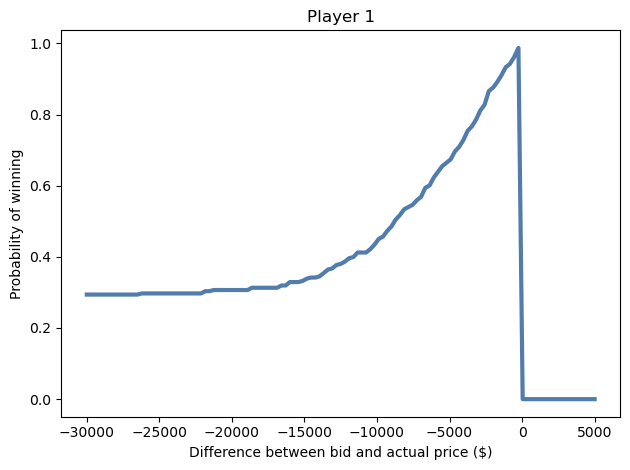

In [79]:
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff2) for x in xs]

plt.plot(xs, ys)

decorate(xlabel='Difference between bid and actual price ($)',
         ylabel='Probability of winning',
         title='Player 1')

#### \\$30,000 낮게 입찰했다면, 이길 확률은 30\%가량 되며, 이는 상대방이 실제 가격보다 높게 입찰한 경우
#### 입찰가가 실제 가격과 근접해질수록, 이길 확률은 1에 가까워짐

<br>

### 2번 참가자 관점에서의 분석

1. 1번 참가자가 높은 금액을 입찰할 확률
2. 1번 참가자가 \\$9,000 이상으로 차이가 나는 낮은 금액을 입찰할 확률
3. \\$5,000 낮게 입찰한 경우, 2번 참가자가 이길 확률

In [80]:
prob_worse_than(-9000, sample_diff1)

0.19808306709265175

In [83]:
compute_prob_win(-5000, sample_diff1)

0.6453674121405751

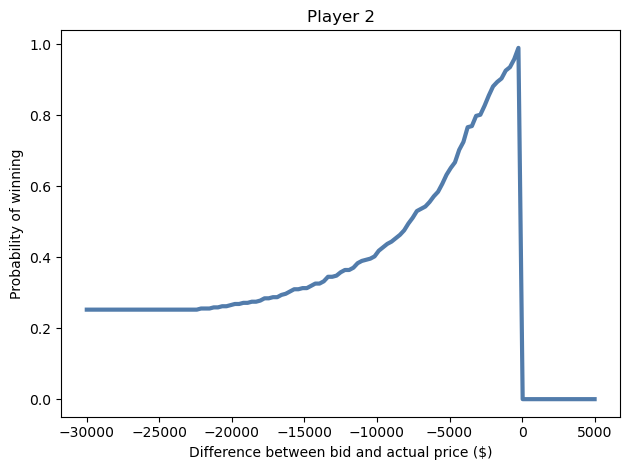

In [82]:
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff1) for x in xs]

plt.plot(xs, ys)

decorate(xlabel='Difference between bid and actual price ($)',
         ylabel='Probability of winning',
         title='Player 2')

<br>

## 09.07. 의사결정분석

- 실제 참가자들은 실제 진열대의 물건들의 가격을 모르므로, 그들이 얼마만큼 낮게 입찰했는지는 알 수 없음
- 하지만, 참가자의 실제 금액에 대한 믿음을 사후확률분포로 나타낼 수 있고, 이를 통해 주어진 입찰가로 이길 확률을 추정 가능

<br>

#### 입찰가, 실제 가격에 대한 사후확률분포, 상대박의 금액 차이 샘플을 사용하여, 다음을 계산

1. 입찰가와 가설 가격의 차이

2. 주어진 차이 값으로 참가자가 이길 확률을 구함

3. 확률의 가중치 합을 구함 (이 때 가중치는 사후분포에서의 확률값)

In [84]:
def total_prob_win(bid, posterior, sample_diff):
    
    """주어진 입찰가로 이길 총 확률을 구함

    bid: 입찰가
    posterior: 진열대 물건 값의 Pmf
    sample_diff: 상대방의 값 차이의 샘플
    
    returns: 이길 확률
    """
    total = 0
    for price, prob in posterior.items():
        diff = bid - price
        total += prob * compute_prob_win(diff, sample_diff)
        
    return total

**이 반복문은 전체확률의 법칙을 구현**

$$P(win) = \sum_{price} P(price) ~ P(win ~|~ price)$$

<br>

- 1번 참가자가 \\$25,000을 입찰했고, 그의 사후분포를 사용할 때 이길 확률

In [85]:
total_prob_win(25000, posterior1, sample_diff2)

0.4842210945439813

<br>

#### 가능한 입찰가 수열에 대해 반복적으로 실행해서, 각 참가자의 최종 승률을 계산 가능
- **1번 참가자의 승률에 대한 분포**

In [87]:
bids = posterior1.qs

probs = [total_prob_win(bid, posterior1, sample_diff2) for bid in bids]

prob_win_series = pd.Series(probs, index=bids)

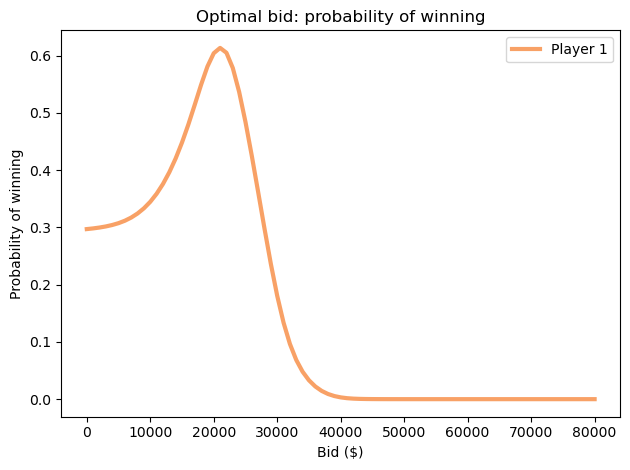

In [88]:
prob_win_series.plot(label='Player 1', color='C1')

decorate(xlabel='Bid ($)',
         ylabel='Probability of winning',
         title='Optimal bid: probability of winning')

<br>

#### **1번 참가자가 이길 확률이 최대인 입찰가**
- **\\$21,000에서 61\%의 승률**

In [89]:
prob_win_series.idxmax()

21000.0

In [90]:
prob_win_series.max()

0.6136807192359475

<br>

#### \\$23,000을 추측하여, \\$26,000을 평균으로 가지는 사후분포가 나왔지만,
#### 가장 높은 승률을 가지는 입찰가는 \\$21,000

<br>

### 2번 참가자의 승률에 대한 분포

In [91]:
bids = posterior2.qs

probs = [total_prob_win(bid, posterior2, sample_diff1) for bid in bids]

prob_win_series = pd.Series(probs, index=bids)

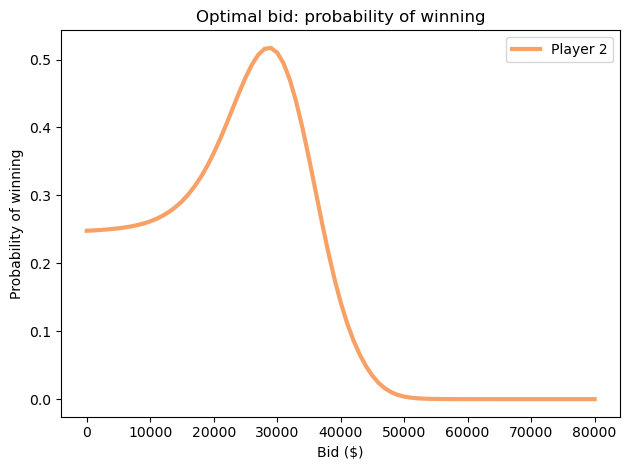

In [92]:
prob_win_series.plot(label='Player 2', color='C1')

decorate(xlabel='Bid ($)',
         ylabel='Probability of winning',
         title='Optimal bid: probability of winning')

In [93]:
prob_win_series.idxmax()

29000.0

In [94]:
prob_win_series.max()

0.5171370053364229

<br>

## 09.08. 예상 수익 최대화

- **게임에서, 입찰가가 실제가보다 \\$250이나 그 이하의 값 차이로 적다면**

    **참가자는 두 진열대에 대해서 모두 승리 가능**
    
    **$\rightarrow$ 입찰가를 조금 늘리는 것도 좋은 전략이 될 수 있음**
    
    **$\rightarrow$ 입찰가가 커지면서 실제 값보다 초과한 입찰로 질 확률도 높아지지만, 양쪽의 진열대에 대해서 모두 이길 확률 역시 증가**

In [95]:
def compute_gain(bid, price, sample_diff):
    
    """입찰가와 실제 금액을 사용해 예상 수익을 계산"""
    diff = bid - price
    prob = compute_prob_win(diff, sample_diff)

    """250달러 이내의 차이면, 양쪽 모두 승리"""
    if -250 <= diff <= 0:
        return 2 * price * prob
    else:
        return price * prob

<br>

- **실제 금액이 \\$35,000이고, 참가자가 \\$30,000을 걸었다면**

    **질 확률, 한 쪽만 이길 확률, 양쪽 모두 이길 확률을 고려했을 때, 평균 \\$23,000을 받을 수 있음**

In [97]:
compute_gain(30000, 35000, sample_diff2)

23594.249201277955

<br>

- **현실적으로 실제 금액을 알 수 없지만, 사후확률분포를 사용하여**

    **사후분포의 확률과 가격을 평균내어, 특정 입찰가에 대해 예상 수익을 계산 가능**

In [98]:
def expected_gain(bid, posterior, sample_diff):
    
    """주어진 입찰가에 대한 예상 수익을 계산"""
    total = 0
    for price, prob in posterior.items():
        total += prob * compute_gain(bid, price, sample_diff)
    return total

- \\$23,000으로 값을 추측해서, \\$21,000을 입찰했을 때의 예상 수익은 \\$16,900

In [99]:
expected_gain(21000, posterior1, sample_diff2)

16923.59933856512

<br>

#### 입찰가의 범위에 대해 반복적으로 탐색해서, 최대 예상 수익을 탐색

In [100]:
bids = posterior1.qs

gains = [expected_gain(bid, posterior1, sample_diff2) for bid in bids]

expected_gain_series = pd.Series(gains, index=bids)

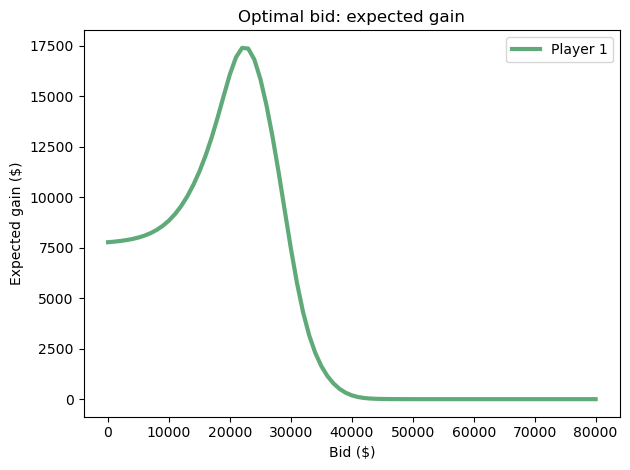

In [101]:
expected_gain_series.plot(label='Player 1', color='C2')

decorate(xlabel='Bid ($)',
         ylabel='Expected gain ($)',
         title='Optimal bid: expected gain')

- 최적의 입찰가는 \\$22,000이며, 이 입찰가에서 예상 수익은 약 \\$17,400

In [103]:
expected_gain_series.idxmax()

22000.0

In [104]:
expected_gain_series.max()

17384.8995844308

#### 처음 추측한 금액은 \\$23,000
#### 우승 확률을 가장 높이는 입찰가는 \\$21,000
#### 최대 예상 금액을 내는 입찰가는 \\$22,000

<br>

## 09.10. 빈도주의 vs 베이지안
### 베이지안 방식과 빈도주의적 방식의 결과가 동일?
#### 베이지안과 빈도주의 방법은 결과종류에서 차이가 존재
- **빈도주의 방식의 결과는 보통 (여러 조건 중 하나에 따른) 최상의 추정치인 단일값이거나, 추정값의 정밀도를 수치화한 구간**
- **베이지안 방식의 결과는 모든 가능한 결과와 각 결과의 확률로 나타나는 사후분포**

<br>

**사후분포를 사용하여 '최상의; 추정치를 선택하거나, 구간을 구할 수 있음**

**이 경우, 결과는 빈도주의에서의 추정치와 동일할 수 있음. 하지만 유용한 정보를 잃을 수 있고**

**사후분포는 단일값이나 구간보다는 더욱 유용하다는 베이지안 방식의 기본적인 장점이 사라질 수 있음**

<br>

**값이 아무리 최적이라고 해도, 단일 추정값이나 구간값으로는 구할 수 없음**

**일반적으로 빈도주의 추정값은 의사결정을 이끌 정보를 거의 주지 못함**
